# Data Extraction

In [1]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import datetime 
import csv

In [2]:
# Data about the crypto to be analized 
coin = 'full_data_BNT_30072020.csv'


In [3]:
# There is no issue with start date, the one that is typed is the first from the BTC but it works for * cryptos 
today = datetime.date.today()
mktcap_page = 'https://coinmarketcap.com/currencies/bancor/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
page = urllib2.urlopen(mktcap_page)
soup = BeautifulSoup(page, 'html.parser')
table = soup.find("table")

In [4]:
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]
headings = [x.replace('*','') for x in headings]
headings

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

In [5]:
datasets = []

for row in soup.find_all("tr")[1:]:
    dataset = dict(zip(headings, (tr.get_text() for tr in row.find_all("td"))))
    if len(dataset) > 1:
        datasets.append(dataset)

datasets[0]

{'Close': '1.70',
 'Date': 'Jul 30, 2020',
 'High': '1.70',
 'Low': '1.45',
 'Market Cap': '117,348,825',
 'Open': '1.47',
 'Volume': '59,595,822'}

In [6]:
my_df = pd.DataFrame(datasets)
full_data = my_df.set_index('Date')
#full_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
full_data.to_csv(coin, index=True, header=True)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 30, 2020",1.47,1.70,1.45,1.70,"59,595,822","117,348,825"
"Jul 29, 2020",1.48,1.57,1.46,1.47,"45,401,736","101,670,060"
"Jul 28, 2020",1.35,1.56,1.32,1.48,"58,245,291","102,552,980"
"Jul 27, 2020",1.43,1.48,1.29,1.35,"59,728,334","93,232,790"
"Jul 26, 2020",1.39,1.68,1.21,1.42,"85,855,924","98,533,541"


In [7]:
full_data.shape

(1139, 6)

In [8]:
full_data.dtypes

Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

In [9]:
def obj_to_int(x):
    x = x.replace(',','')
    return float(x)
full_data['Low'] = full_data['Low'].apply(obj_to_int)
full_data['High'] = full_data['High'].apply(obj_to_int)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 30, 2020",1.47,1.70,1.45,1.70,"59,595,822","117,348,825"
"Jul 29, 2020",1.48,1.57,1.46,1.47,"45,401,736","101,670,060"
"Jul 28, 2020",1.35,1.56,1.32,1.48,"58,245,291","102,552,980"
"Jul 27, 2020",1.43,1.48,1.29,1.35,"59,728,334","93,232,790"
"Jul 26, 2020",1.39,1.68,1.21,1.42,"85,855,924","98,533,541"


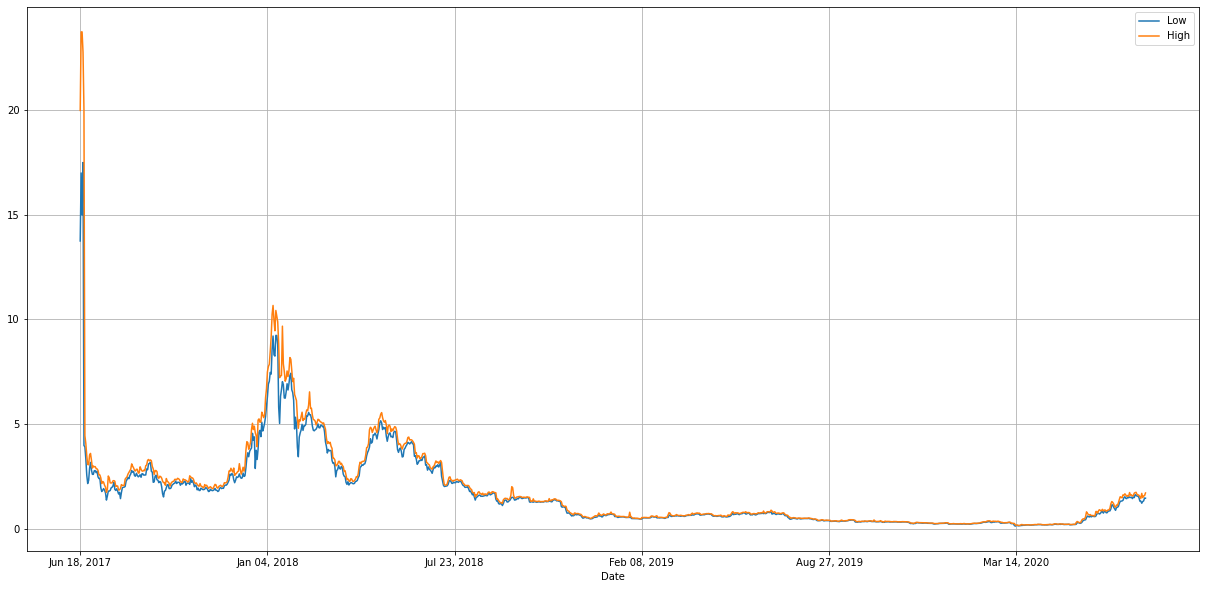

In [10]:
_= full_data[['Low','High']][::-1].plot(grid=True, figsize=(21, 10))

# Preparing data for time series

In [19]:
# This function replaces ',' for nothing and then changes data type object to float

def obj_to_num(df,cols):
    
    def obj_to_num(row):
        if ',' in str(row):
          row = row.replace(',','')
          return float(row)
        else:
          return float(row)

    for col in cols:     
        df[col] = df[col].apply(obj_to_num) 
    return df

# This function changes data column (object) to timestamp[ns] and also can change all dataframe clumns to float 

def prepare_data(file):

  dateparse = lambda x: datetime.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d')
  data  = pd.read_csv(file, parse_dates=[0], date_parser=dateparse)
  columns = ['Open','High','Low','Close','Volume','Market Cap']
  num_data = obj_to_num(data,columns)
  data['Date'] = data['Date'].dt.tz_localize(None)
  data = data.groupby([pd.Grouper(key='Date', freq='d')]).first().reset_index()
  data = data.set_index('Date')
  data = data[['High','Low']]
  data.dropna(subset=['High','Low'], inplace=True)

  return data

In [20]:
file = coin
data = prepare_data(file)
data.head()

,High,Low
Date,,
2017-06-18,19.98,13.74
2017-06-19,23.73,16.99
2017-06-20,23.73,14.99
2017-06-21,22.76,17.49
2017-06-22,20.01,3.97


In [21]:
data.index

DatetimeIndex(['2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
               '2017-06-26', '2017-06-27',
               ...
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30'],
              dtype='datetime64[ns]', name='Date', length=1139, freq=None)

In [22]:
!pip install chart_studio

In [23]:
import plotly.graph_objects as go
import chart_studio as py

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
py.tools.set_credentials_file(username='xxxxxxxx', api_key='xxxxxxxx')

In [25]:
trace1 = go.Scatter(
    x = data.index,
    y = data['High'].astype(float),
    mode = 'lines',
    name = 'Bancor Price (High)'
)
trace2 = go.Scatter(
    x = data.index,
    y = data['Low'].astype(float),
    mode = 'lines',
    name = 'Bancor Price (High)'
)

layout = dict(
    title='Historical bancor High and Low price (USD) (...-2020)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2]
fig = dict(data = data.copy(), layout=layout)
py.plotly.iplot(fig, filename = "Time Series with Rangeslider")

# Sarimax Model

## To trade dayli we want to know low and high prices on x number of days the closer the predictions are the more accurate result we have

In [26]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

In [27]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import matplotlib.pyplot as plt

In [28]:
# We do this again because the fo@#!ing pyplot plot changed data types 
file = coin
data = prepare_data(file)

In [29]:
data.head()

,High,Low
Date,,
2017-06-18,19.98,13.74
2017-06-19,23.73,16.99
2017-06-20,23.73,14.99
2017-06-21,22.76,17.49
2017-06-22,20.01,3.97


In [30]:
data.index

DatetimeIndex(['2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
               '2017-06-26', '2017-06-27',
               ...
               '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
               '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30'],
              dtype='datetime64[ns]', name='Date', length=1139, freq=None)

In [31]:
data_high = pd.DataFrame(data['High'].copy())
data_high.head()

,High
Date,
2017-06-18,19.98
2017-06-19,23.73
2017-06-20,23.73
2017-06-21,22.76
2017-06-22,20.01


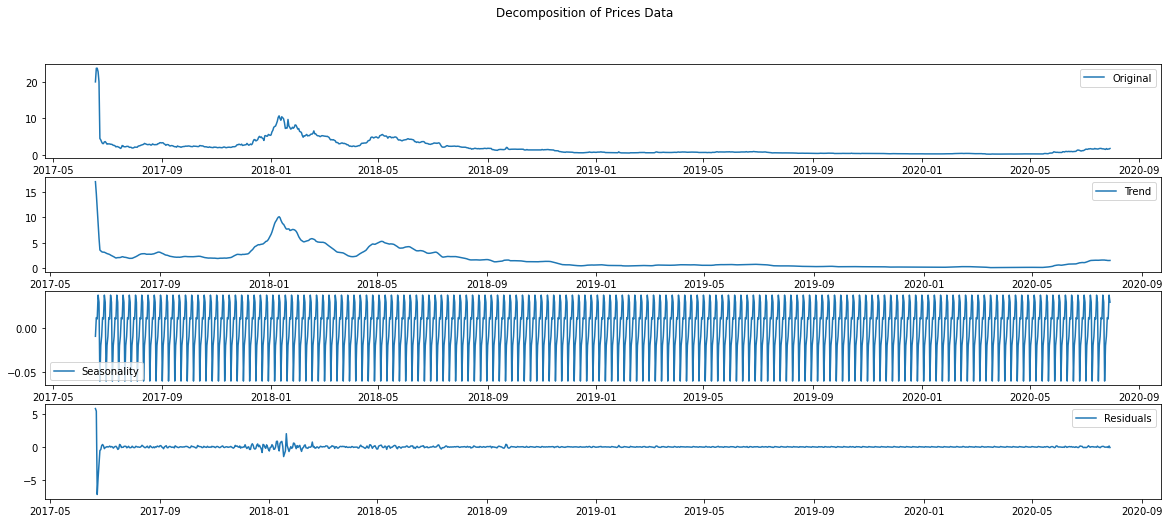

In [32]:
decomposition = sm.tsa.seasonal_decompose(data_high)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data_high, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [33]:
# Test for p-value and null hypotesis
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.High)[1])

Dickey–Fuller test: p=0.368070


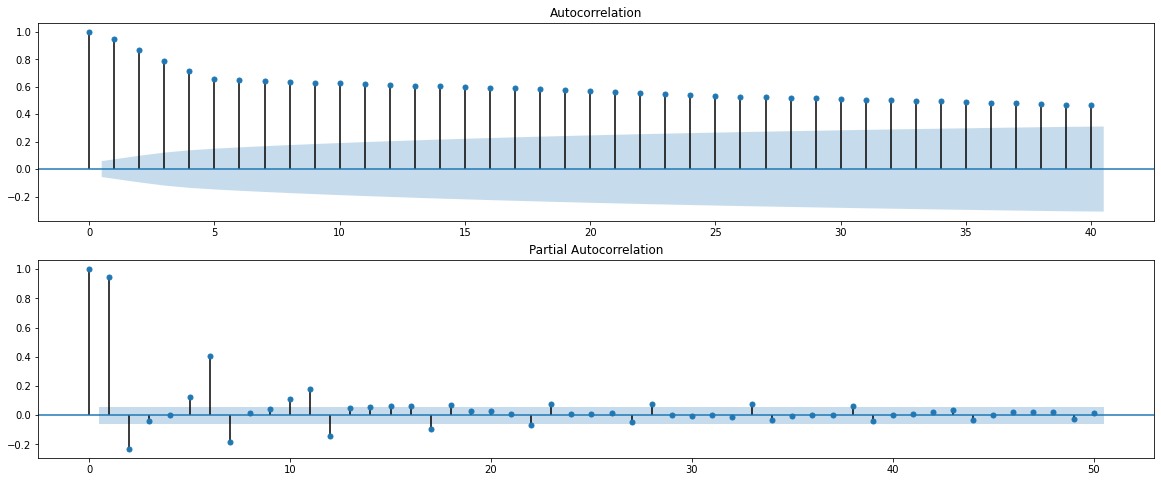

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.High, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(data.High, ax=pyplot.gca(), lags=50)
pyplot.show()

In [35]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Dickey–Fuller test:: p=0.000000


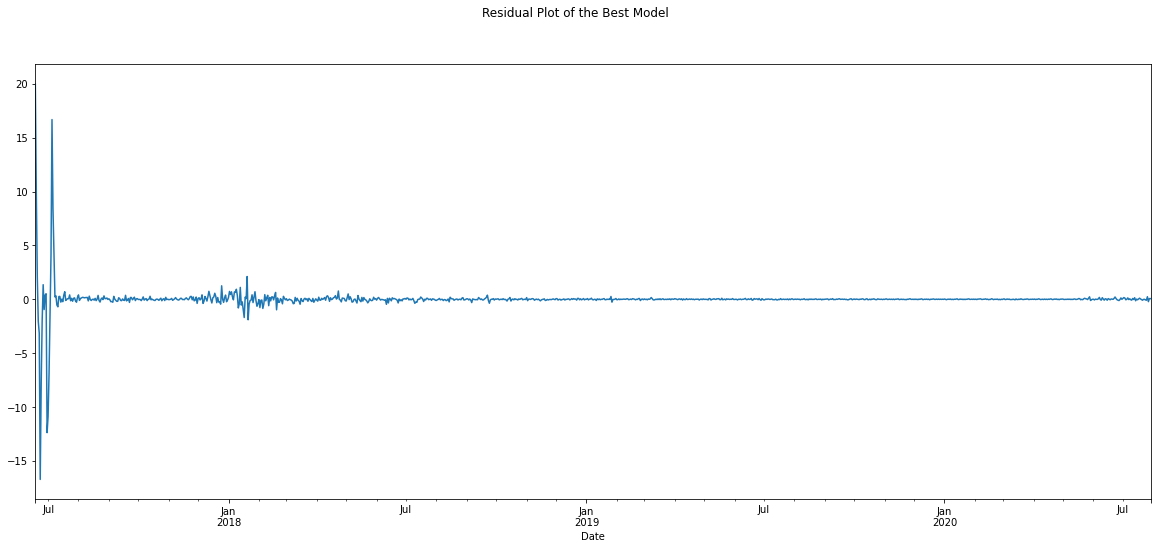

In [36]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

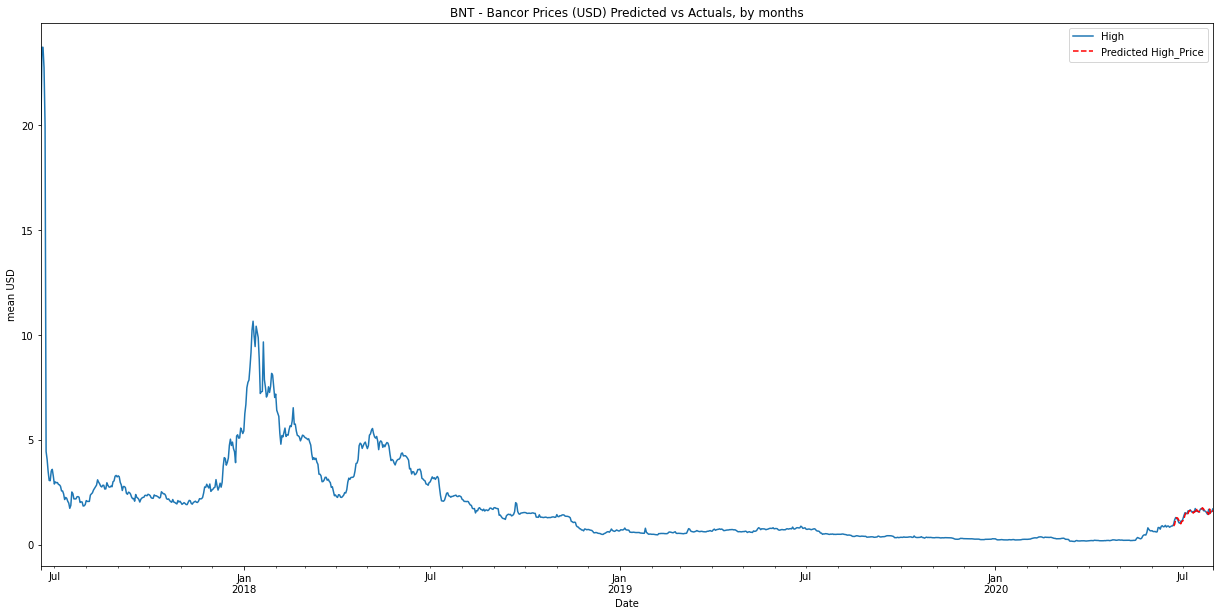

In [37]:
df_month2 = data[['High']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=1100, end=1139)
plt.figure(figsize=(21,10))
df_month2.High.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted High_Price')
plt.legend()
plt.title('BNT - Bancor Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()

In [38]:
df_month2['forecast'] = best_model.predict(start=1119, end=1139)
df_month2[-20:]

,High,forecast
Date,,
2020-07-11,1.58,1.501349
2020-07-12,1.54,1.556748
2020-07-13,1.72,1.573302
2020-07-14,1.59,1.722772
2020-07-15,1.61,1.593188
2020-07-16,1.55,1.593603
2020-07-17,1.58,1.554480
2020-07-18,1.69,1.584096
2020-07-19,1.72,1.687123


In [40]:
# 30/07/2020 = 1139 so lets see what would be the price in the next 6 days
best_model.predict(start=1138, end=1144)

2020-07-30    1.631789
2020-07-31    1.675031
2020-08-01    1.692452
2020-08-02    1.689047
2020-08-03    1.684923
2020-08-04    1.666770
2020-08-05    1.640197
Freq: D, dtype: float64